In [16]:
import pandas as pd
import numpy as np
import requests
import json
import tweepy
import os

## Gathering Data

In [17]:
twitarch_df = pd.read_csv('twitter-archive-enhanced-2.csv')

In [18]:
# https://developer.twitter.com/en/docs/authentication/guides/authentication-best-practices
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")

# from http://docs.tweepy.org/en/latest/getting_started.html
# using Oauth 2
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
# https://knowledge.udacity.com/questions/66949#66975
api = tweepy.API(auth_handler = auth,
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

```
Rate limit reached. Sleeping for: 607
Rate limit reached. Sleeping for: 606
```

### code above ran for 32 minutes
I started execution at 14:30 on 2020-08-24 (Aug 24 2020). It finished around 15:02

In [19]:
# get the info from json object that will be merged with original df
added_features = []

with open('tweet_json.txt', 'r') as file:
    for item in file:
        data = json.loads(item)
        added_features.append({'tweet_id': data['id'],
                               'favorite_count': data['favorite_count'],
                               'retweet_count': data['retweet_count']})

added_fields = pd.DataFrame(added_features)

### The project details gave 2 different URLs for the image predictions data. I will compare the 2 below.

In [20]:
# project gave us 2 different links. They are identical
!diff -s image_predictions.tsv image_predictions_2.tsv

Files image_predictions.tsv and image_predictions_2.tsv are identical


### Since the 2 image_predictions files are identical, I will use the file extracted from first URL.

In [21]:
imagepred_df = pd.read_csv('image_predictions.tsv', sep='\t')

-----------------------

## Assess Data

In [22]:
twitarch_df.info()
twitarch_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [23]:
# Are all the tweet_ids unique?
print(f"There are {twitarch_df.shape[0]} entries and there are {twitarch_df.tweet_id.nunique()} unique tweet_ids")

There are 2356 entries and there are 2356 unique tweet_ids


All tweet_ids are unique since there are 2356 entries and there are 2356 unique IDs

In [24]:
added_fields.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35783,7568
1,892177421306343426,30896,5607
2,891815181378084864,23249,3714
3,891689557279858688,39055,7746
4,891327558926688256,37301,8346


In [25]:
imagepred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:

imagepred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [27]:
twitarch_df[twitarch_df['text'].str.contains('pupper', regex=True) & (twitarch_df['pupper'] != 'pupper')].count()

tweet_id                      24
in_reply_to_status_id          1
in_reply_to_user_id            1
timestamp                     24
source                        24
text                          24
retweeted_status_id            0
retweeted_status_user_id       0
retweeted_status_timestamp     0
expanded_urls                 24
rating_numerator              24
rating_denominator            24
name                          24
doggo                         24
floofer                       24
pupper                        24
puppo                         24
dtype: int64

In [28]:
twitarch_df['text'].str.contains('doggo|pupper|puppo|floofer').sum()

399

In [29]:
twitarch_df[(twitarch_df['text'].str.contains('^RT', regex=True)) & (twitarch_df['retweeted_status_id'].isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1286,708400866336894977,NaN,NaN,2016-03-11 21:15:02 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",RT if you are as ready for summer as this pup ...,NaN,NaN,NaN,https://vine.co/v/iHFqnjKVbIQ,12,10,None,None,None,None,None
1860,675489971617296384,NaN,NaN,2015-12-12 01:38:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT until we find this dog. Clearly a cool dog ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675489971...,10,10,None,None,None,None,None


In [42]:
twitarch_df[twitarch_df['text'].str.contains('doggo|pupper|puppo|floofer') & (twitarch_df['doggo'] == 'None') & (twitarch_df['floofer'] == 'None') & (twitarch_df['pupper'] == 'None') & (twitarch_df['puppo'] == 'None')].count()

tweet_id                      41
in_reply_to_status_id          3
in_reply_to_user_id            3
timestamp                     41
source                        41
text                          41
retweeted_status_id            2
retweeted_status_user_id       2
retweeted_status_timestamp     2
expanded_urls                 39
rating_numerator              41
rating_denominator            41
name                          41
doggo                         41
floofer                       41
pupper                        41
puppo                         41
dtype: int64

In [38]:
twitarch_df[twitarch_df['doggo'] == 'None'].count()

tweet_id                      2259
in_reply_to_status_id           74
in_reply_to_user_id             74
timestamp                     2259
source                        2259
text                          2259
retweeted_status_id            171
retweeted_status_user_id       171
retweeted_status_timestamp     171
expanded_urls                 2203
rating_numerator              2259
rating_denominator            2259
name                          2259
doggo                         2259
floofer                       2259
pupper                        2259
puppo                         2259
dtype: int64

In [35]:
twitarch_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## Clean data

In [317]:
# make copies
twitarch_work = twitarch_df.copy()
#imagepred_work = imagepred_df.copy()
#addedfields_work = added_fields.copy()

In [318]:
# according to project details drop "no retweets" when it comes to original ratings
# I will not drop them in the meantime
retweets = twitarch_work[twitarch_work.retweeted_status_id.notnull()].index
retweets[:5]

Int64Index([19, 32, 36, 68, 73], dtype='int64')

In [319]:
#twitarch_work.set_index('tweet_id')
#twitarch_work.head(3)
dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']

In [320]:
#temp = twitarch_work[dog_stage]

In [321]:
#twitarch_work.replace(to_replace={'None': None}, value=None, method=None, inplace=True)
for ds in dog_stage:
    twitarch_work[ds].replace({'None': np.nan}, inplace=True)

In [322]:
twitarch_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       97 no

In [167]:
#temp[dog_stage].notnull().sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [323]:
# create a new column that sums by row the dog_stages
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1)

In [324]:
twitarch_work[dog_stage + ['ds_sum']].head()

,doggo,floofer,pupper,puppo,ds_sum
0,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,0


In [325]:
#twitarch_work[twitarch_work.ds_sum > 1].count()

In [326]:
# get all the indices of specific dog stages, then write into cell the dog stage
for ds in dog_stage:
    tidx = twitarch_work[(twitarch_work.text.str.contains(ds, case=False)) & (twitarch_work['ds_sum'] == 0)].index
    # for all the indices found for that dog stage, write the dog stage
    twitarch_work.loc[tidx, ds] = ds

In [327]:
# create a new column that sums by row the dog_stages
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1)

In [219]:
#twitarch_work.loc[doggo_idx, ['text', 'doggo']]

,text,doggo
83,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,doggo
268,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL,doggo
302,"RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…",doggo
475,RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://…,doggo
477,Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p,doggo
798,You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV,doggo
934,Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for this time of year. 11/10 for all https://t.co/CCdlwiTwQf,doggo
946,Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ,doggo
987,This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort https://t.co/U8cSRz8wzC,doggo
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,doggo


In [328]:
twitarch_work.to_csv('twitarch_work.csv', index=False)

In [329]:
# verify that text containing a dog stage are accounted for
twitarch_work[(twitarch_work.text.str.contains('doggo|pupper|puppo|floofer', case=False)) & (twitarch_work['ds_sum'] == 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ds_sum


In [332]:
ds_counts = []
for ds in dog_stage:
    ds_counts.append(twitarch_work[ds].value_counts()[0])
ds_counts

[107, 10, 283, 37]

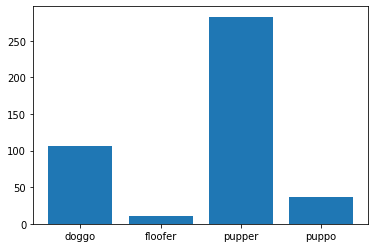

In [333]:
# Let us see a quick visual of frequency of dog stages. It did not matter to me if some tweets had content in more than one dog stage

import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(dog_stage, ds_counts);

In [339]:
# create a new column to combine content from the 4 columns of dog stages
combo_idx = twitarch_work[twitarch_work.ds_sum > 1].index
twitarch_work['dog_stage'] = twitarch_work['doggo'].fillna('').map(str) + twitarch_work['floofer'].fillna('').map(str) + twitarch_work['pupper'].fillna('').map(str) + twitarch_work['puppo'].fillna('').map(str)
# prefix the multiple dog stages with "combo"
twitarch_work.loc[combo_idx, 'dog_stage'] = 'combo-' + twitarch_work['dog_stage']

In [340]:
twitarch_work.dog_stage.value_counts()

                      1933
pupper                 271
doggo                   93
puppo                   36
combo-doggopupper       12
floofer                  9
combo-doggopuppo         1
combo-doggofloofer       1
Name: dog_stage, dtype: int64

In [335]:
twitarch_work.to_csv('twitarch_work.csv', index=False)

In [336]:
twitarch_work.dog_stage.value_counts()

                1933
pupper           271
doggo             93
puppo             36
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64